In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import copy
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
data_dir = '../../Smart Attack Algorithm/data/Car Hacking Dataset/' 
normal_data_path = os.path.join(data_dir, 'benign_data.csv')

In [3]:
benign_data = pd.read_csv(normal_data_path)

In [4]:
benign_data.head()

,Timestamp,ID,DLC,Payload,label
0,1.479121e+09,0350,8,052884666d0000a2,0
1,1.479121e+09,02c0,8,1400000000000000,0
2,1.479121e+09,0430,8,0000000000000000,0
3,1.479121e+09,04b1,8,0000000000000000,0
4,1.479121e+09,01f1,8,0000000000000000,0


In [5]:
def data_len(df):
    if 'Timestamp' in df.columns:
        # Ensure the Timestamp column is sorted
        df = df.sort_values(by='Timestamp')
        
        # Compute time difference
        time_diff = df['Timestamp'].iloc[-1] - df['Timestamp'].iloc[0]
        
        # Convert to HH:MM:SS:Milliseconds format
        hours, remainder = divmod(time_diff, 3600)
        minutes, remainder = divmod(remainder, 60)
        seconds, milliseconds = divmod(remainder, 1)
        
        time_str = f"{int(hours):02}:{int(minutes):02}:{int(seconds):02}:{int(milliseconds * 1000):03}"
        
        return time_str
    else:
        return "Timestamp column not found in dataframe"

In [6]:
hex_to_dec = lambda x: int(str(x), 16) if isinstance(x, str) else x

def transform_data(data):

    data['ID'] = data['ID'].apply(hex_to_dec)
    data['Payload'] = data['Payload'].apply(hex_to_dec)

    return data

# Function to handle conversion
def convert_hex_column(column):
    def convert_value(value):
        try:
            # Try to convert using hex_to_dec
            return hex_to_dec(value)
        except ValueError:
            # If ValueError occurs, it means the value is in scientific notation
            return int(float(value))
    
    return column.apply(convert_value)


benign_data = transform_data(benign_data)


In [7]:
data_len(benign_data)

'00:08:26:436'

In [8]:
train_data, val_data = train_test_split(benign_data, test_size=0.8, shuffle=False)

In [9]:
train_data

,Timestamp,ID,DLC,Payload,label
0,1.479121e+09,848,8,371692544708313250,0
1,1.479121e+09,704,8,1441151880758558720,0
2,1.479121e+09,1072,8,0,0
3,1.479121e+09,1201,8,0,0
4,1.479121e+09,497,8,0,0
...,...,...,...,...,...
197769,1.479122e+09,1088,8,18375543003512179035,0
197770,1.479122e+09,2,8,65883,0
197771,1.479122e+09,339,8,1095233372160,0
197772,1.479122e+09,304,8,18266038235715010892,0


In [10]:
def create_transition_matrix(data):

    start_time = time.time() 

    id_list = data['ID'].to_list()

    unique_ids = list(set(id_list))

    print(f"There are {len(unique_ids)} unique keys in this dataset")

    transition_matrix = {key : [False] * len(unique_ids) for key in unique_ids}

    for i in tqdm(range(len(id_list) - 1)):
        ##Extracting ID pair to check in transition matrix
        first_id = id_list[i]
        second_id = id_list[i+1]

        if transition_matrix[first_id][unique_ids.index(second_id)]:
            continue
        else:
            transition_matrix[first_id][unique_ids.index(second_id)] = True

    end_time = time.time()
    execution_time = end_time - start_time

    print(f"Function execution time for dataset with {len(id_list)} items : {execution_time:.4f} seconds")

    return transition_matrix, unique_ids

ch_tm, ch_unique_ids = create_transition_matrix(train_data)

There are 27 unique keys in this dataset


100%|██████████| 197773/197773 [00:00<00:00, 2473189.38it/s]

Function execution time for dataset with 197774 items : 0.1027 seconds


In [11]:
# ch_val_tm, ch_val_unique_ids = create_transition_matrix(val_data)

In [12]:
def validation(val_data, transition_matrix, unique_ids):

    """
        val_data : validation data 
        transition_matrix: transition matrix
        unique_ids: list of unique ids in training data
    """
    
    ##SHOULD I MAKE IT MORE EFFICIENT BY DOING ID verification first?


    start_time = time.time() 

    fpr_count = 0

    keys = transition_matrix.keys()

    val_data_ids = val_data['ID'].to_list()

    for i in tqdm(range(len(val_data_ids) - 1)):

        first_id = val_data_ids[i]
        second_id = val_data_ids[i+1]

        ## Check if both keys are in transition matrix

        if (first_id in list(keys)) and (second_id in list(keys)):

            ##Check if transition is valid
            if transition_matrix[first_id][unique_ids.index(second_id)]:
                continue
            else: 
                ## If not valid, then increase False Positive Rate Count, and update the matrix
                fpr_count += 1
                transition_matrix[first_id][unique_ids.index(second_id)] = True
        
        else:
            raise ValueError(f"{first_id} or {second_id} ID Not Found, Exiting Validation Process")
            
    
    ## Calculate False Positive Rate
    fpr = fpr_count / len(val_data_ids)
    print(f"False Positive Rate: {fpr:.4f}")
        
    end_time = time.time()
    execution_time = end_time - start_time


    print(f"Function execution time for dataset with {len(val_data_ids)} items : {execution_time:.4f} seconds")

    return transition_matrix

In [13]:
validated_ch_tm = copy.deepcopy(ch_tm)
validated_ch_tm = validation(val_data, validated_ch_tm, ch_unique_ids)

100%|██████████| 791096/791096 [00:00<00:00, 1397227.07it/s]

False Positive Rate: 0.0000
Function execution time for dataset with 791097 items : 0.5763 seconds


In [14]:
def visualize_dict_as_matrix(data_dict, plot_title = None, cell_size=20, grid_color='black', grid_width=1):
    """
    Convert a dictionary with boolean lists into a visual matrix image.
    
    Parameters:
    - data_dict: Dictionary where each value is a list of boolean values
    - cell_size: Size of each cell in pixels (higher value = higher resolution)
    - grid_color: Color of the grid lines
    - grid_width: Width of the grid lines
    
    Returns:
    - Displays and saves the matrix visualization
    """
    # Verify all lists are the same length and match the number of keys
    keys = list(data_dict.keys())
    n = len(keys)
    if any(len(data_dict[key]) != n for key in keys):
        raise ValueError("All lists must have the same length as the number of keys")

    # Create an n×n matrix filled with boolean values from the dictionary
    matrix = np.zeros((n, n), dtype=bool)
    
    # Fill the matrix with values from the dictionary
    for i, key in enumerate(keys):
        matrix[i] = data_dict[key]
    
    # Calculate figure size and resolution
    figsize = (n * cell_size / 100, n * cell_size / 100)
    dpi = 100
    
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    
    # Create the heatmap (red for False, green for True)
    cmap = plt.matplotlib.colors.ListedColormap(['red', 'green'])
    
    # Plot the matrix
    im = ax.imshow(matrix, cmap=cmap, interpolation='none')
    
    # Add grid lines
    for i in range(n+1):
        ax.axhline(i-0.5, color=grid_color, linewidth=grid_width)
        ax.axvline(i-0.5, color=grid_color, linewidth=grid_width)
    
    # Remove ticks but keep labels if needed
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(keys)
    ax.set_yticklabels(keys)
    
    # Set title and labels
    if plot_title:
        ax.set_title(plot_title)
    
    # Optional: customize tick parameters
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Adjust layout
    plt.tight_layout()
    
    # Save the figure
    # plt.savefig('matrix_visualization.png', bbox_inches='tight', dpi=dpi*2)
    
    # Display the figure
    plt.show()
    
    return fig, ax

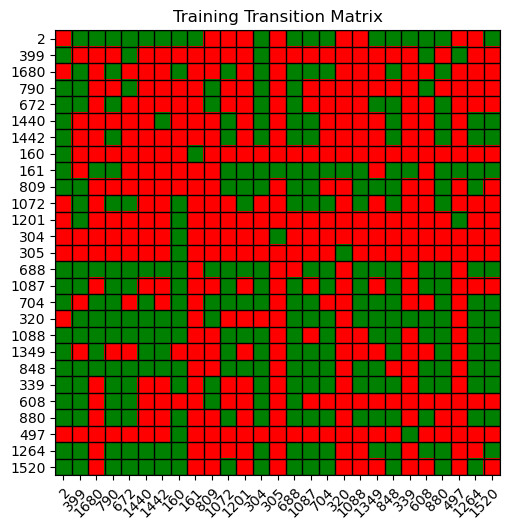

(<Figure size 540x540 with 1 Axes>,
 <Axes: title={'center': 'Training Transition Matrix'}>)

In [15]:
visualize_dict_as_matrix(ch_tm, "Training Transition Matrix")

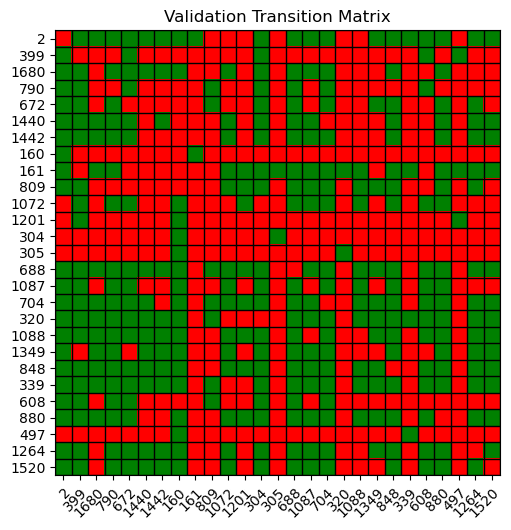

(<Figure size 540x540 with 1 Axes>,
 <Axes: title={'center': 'Validation Transition Matrix'}>)

In [16]:
visualize_dict_as_matrix(validated_ch_tm, "Validation Transition Matrix")

In [17]:
def shift_columns(df):
    
    for dlc in [2,5,6]:

        df.loc[df['DLC'] == dlc, df.columns[3:]] = df.loc[df['DLC'] == dlc, df.columns[3:]].shift(periods=8-dlc, axis='columns', fill_value='00')

    return df

def read_ch_data(data_path):
    
    columns = ['Timestamp','ID', 'DLC', 'data0', 'data1', 'data2', 'data3', 'data4', 
           'data5', 'data6', 'data7', 'label']
    
    data = pd.read_csv(data_path, names = columns)

    data = shift_columns(data)
    
    ##Replacing all NaNs with '00' 
    data = data.replace(np.NaN, '00')
    
    ##Joining all data columns to put all data in one column
    data_cols = ['data0', 'data1', 'data2', 'data3', 'data4', 'data5', 'data6', 'data7']
    
    ##The data column is in hexadecimal
    data['Payload'] = data[data_cols].apply(''.join, axis=1)
    data.drop(columns = data_cols, inplace = True, axis = 1)
        
    data = data.assign(IAT=data['Timestamp'].diff().fillna(0))
    data = data[['Timestamp', 'ID','DLC','Payload', 'IAT', 'label']]
    data['label'].replace({'R' : 0, 'T' : 1}, inplace = True)
    
    return data

In [18]:
dos_dataset_path =os.path.join(data_dir, 'DoS_dataset.csv')
dos_dataset = read_ch_data(dos_dataset_path)
dos_dataset = transform_data(dos_dataset)
dos_dataset.head()

,Timestamp,ID,DLC,Payload,IAT,label
0,1.478198e+09,790,8,369691032840896623,0.000000,0
1,1.478198e+09,399,8,18328243108518297600,0.000209,0
2,1.478198e+09,608,8,1810766114876976442,0.000228,0
3,1.478198e+09,672,8,7205928855671061760,0.000232,0
4,1.478198e+09,809,8,4664461563235663892,0.000237,0


In [19]:
data_len(dos_dataset)

'00:47:12:669'

In [20]:
# test_data_ids = dos_dataset['ID'].to_list()
# predicted_labels = []

# # print(f"Test data length {len(test_data_ids)}")

# for i in tqdm(range(len(test_data_ids) - 1)):
    
#     # print(f"i: {i} i+1 : {i+1}")

#     first_id = test_data_ids[i]
#     second_id = test_data_ids[i+1]

#     ## Check if both ids are in the transition matrix
#     if (first_id in ch_unique_ids) and (second_id in ch_unique_ids):

#         ##Check if transition is valid
#         if validated_ch_tm[first_id][ch_unique_ids.index(second_id)]:
#             predicted_labels.append(0)
#         else: 
#             predicted_labels.append(1)
    
#     else:
#         if first_id not in ch_unique_ids:
#             predicted_labels.append(1)
#         else:
#             predicted_labels.append(0)
    
#     predicted_labels.append(0)

#     true_labels = dos_dataset['label'].to_numpy()
# predicted_labels = np.array(predicted_labels)




100%|██████████| 3665770/3665770 [00:07<00:00, 488232.40it/s]


              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99   3078250
      Attack       0.95      1.00      0.97    587521

    accuracy                           0.99   3665771
   macro avg       0.98      1.00      0.98   3665771
weighted avg       0.99      0.99      0.99   3665771

Accuracy: 0.9916
F1 Score: 0.9745
True Positive Rate (TPR / Recall): 1.0000
False Positive Rate (FPR): 0.0100
False Negative Rate (FNR): 0.0000
True Negative Rate (TNR / Specificity): 0.9900


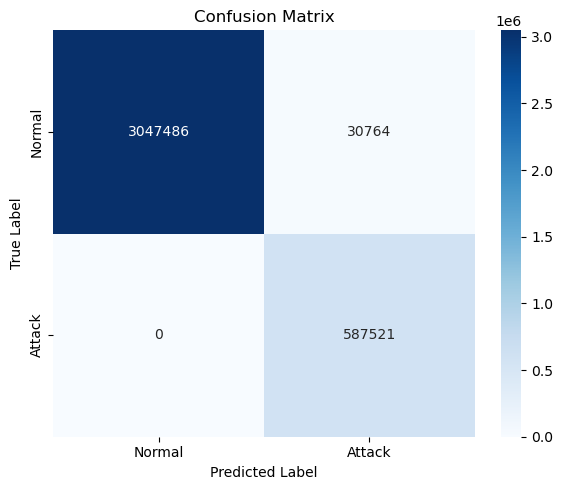

Evaluation time for dataset with 3665771 items: 11.8345 seconds


In [21]:
def test(test_data, validated_tm, training_unique_ids):

    start_time = time.time() 

    test_data_ids = test_data['ID'].to_list()
    predicted_labels = []

    # print(f"Test data length {len(test_data_ids)}")

    for i in tqdm(range(len(test_data_ids) - 1)):
        
        # print(f"i: {i} i+1 : {i+1}")

        first_id = test_data_ids[i]
        second_id = test_data_ids[i+1]

        ## Check if both ids are in the transition matrix
        if (first_id in training_unique_ids) and (second_id in training_unique_ids):

            ##Check if transition is valid
            if validated_tm[first_id][training_unique_ids.index(second_id)]:
                predicted_labels.append(0)
            else: 
                predicted_labels.append(1)
        
        else:
            if first_id not in training_unique_ids:
                predicted_labels.append(1)
            else:
                predicted_labels.append(0)

        true_labels = test_data['label'].to_numpy()
    predicted_labels.append(0)
    predicted_labels = np.array(predicted_labels)

    # Print classification report
    print(classification_report(true_labels, predicted_labels, target_names=['Normal', 'Attack'], zero_division=0))

    # Compute confusion matrix: [[TN, FP], [FN, TP]]
    cm = confusion_matrix(true_labels, predicted_labels)
    TN, FP, FN, TP = cm.ravel()

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    tpr = TP / (TP + FN) if (TP + FN) > 0 else 0  # Sensitivity, Recall
    fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
    fnr = FN / (FN + TP) if (FN + TP) > 0 else 0
    tnr = TN / (TN + FP) if (TN + FP) > 0 else 0  # Specificity

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"True Positive Rate (TPR / Recall): {tpr:.4f}")
    print(f"False Positive Rate (FPR): {fpr:.4f}")
    print(f"False Negative Rate (FNR): {fnr:.4f}")
    print(f"True Negative Rate (TNR / Specificity): {tnr:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Attack'], yticklabels=['Normal', 'Attack'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
    
    end_time = time.time()

    print("Evaluation time for dataset with {} items: {:.4f} seconds".format(len(test_data_ids), end_time - start_time))

test(dos_dataset, validated_ch_tm, ch_unique_ids)